### **PINN code for Porous Media Permeability Upscaling**

#### Load Libraries

In [1]:
# General Libraries
from numpy import sqrt
from numpy import savetxt
import numpy as np
import pandas as pd
from pandas import read_csv
import os
# ML libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.python.keras.utils import losses_utils
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from contextlib import redirect_stdout
# Visualization libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

# Choose GPU to use (8 available) - skip 0 (busy)
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[4:8], 'GPU')
tf.get_logger().setLevel('ERROR')

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

#### Define Custome Functions

In [2]:
def data_aug(data):
    d = data
    del data
    # Augment all features
    data_ext = pd.concat([d, d, d, d, d, d, d, d], ignore_index=True)
    
    # k small orders after fliping along X and Y Dirs
    order = [[1, 2, 3, 4, 5, 6, 7, 8],
             [2, 1, 4, 3, 6, 5, 8, 7],
             [4, 3, 2, 1, 8, 7, 6, 5],
             [3, 4, 1, 2, 7, 8, 5, 6]]
    
     # add k small orders after reversing orders along Z Dir
    for i in range(0, len(order)):
        order.append(order[i][::-1])
     
    # Transpose order array
    order = np.array(order).T

    # small k in X Directions    
    for k in ['kx', 'ky', 'kz', 'p', 'ep']:
        i = 1
        for o in order:
            # get ordered features
            kn1 = k+str(o[0])
            kn2 = k+str(o[1])
            kn3 = k+str(o[2])
            kn4 = k+str(o[3])
            kn5 = k+str(o[4])
            kn6 = k+str(o[5])
            kn7 = k+str(o[6])
            kn8 = k+str(o[7])
            # augment small cubes features           
            data_ext[k+str(i)] = pd.concat([d[kn1], d[kn2], d[kn3], d[kn4], 
                                            d[kn5], d[kn6], d[kn7], d[kn8]], ignore_index=True)                        
            i = i + 1
    
    return data_ext

def data_bal(d, LT, UT, inc, num, fill):

    ran = np.arange(LT, UT, inc)
    # intialize data frame
    d_bal = pd.DataFrame()
    for Lt in ran:
        d_inc = d[(d['KX'] > Lt) & (d['KX'] <= Lt+inc)]
        
        if len(d_inc) > 0:
            if len(d_inc) <= num and fill == False:
                num_ = len(d_inc)
            else:
                num_ = num
        
            d_inc_num = d_inc.sample(n=num_, replace=fill) # True to satisfy num if num > len(d_inc_num)
            d_bal = pd.concat([d_bal, d_inc_num], ignore_index=True)
    
    return d_bal

def get_XY(data):
    X = pd.DataFrame()
    for i in range(1, 9):
        kx = "kx"+str(i)
        ky = "ky"+str(i)
        kz = "kz"+str(i)
        X = pd.concat([X, data[kx], data[ky], data[kz]], axis=1)

    ana_sol = "hat_"+formula
    Y = data[["KX", ana_sol]]

    return X, Y

def data_summary(hat, true, percentile):
    # calc error
    RE = (hat-true)/true
    ARE = RE.abs()    
    # Summarze data in one dataframe
    data_summary = pd.DataFrame(columns=['hat', 'true', 'ARE'], index=range(len(true)))
    data_summary['true'] = true.reset_index(drop=True)
    data_summary['hat'] = hat
    data_summary['ARE'] = ARE.reset_index(drop=True)    
    # 95 percintile of Testing data results
    data_summary = data_summary[(data_summary.ARE < ARE.quantile(percentile))]
    
    return data_summary
    
def print_results(RE_ana, RE, ER):
    print('Testing MARE (Analytical) [%] = '+str(round(RE_ana*100, 1)))
    print('Testing MARE (PINN)       [%] = '+str(round(RE*100, 1)))
    print('Error Reduction           [%] = '+str(round(ER*100, 1)))
    return

# Visualization
def hist(x, bins=30, color='lightgreen', alpha=1, xlabel='xlabel', title='title',
         stat=None, xlim=None, ylim=None, version=''):
    MARE = np.mean(abs(x))
    MedRE = np.median(abs(x))
    plt.hist(x, bins=bins, color=color, alpha=alpha, edgecolor='black', linewidth=0.7)
    
    plt.tick_params(direction="in", pad=5, labelsize=12)
    if ylim != None:
        plt.ylim(ylim[0],ylim[1])
    if xlim != None:
        plt.xlim(xlim[0],xlim[1])
    if stat == False:
        plt.title(title, size=12)
    else:
        MARE = np.mean(abs(x))
        MedRE = np.median(abs(x))
        plt.axvline(MARE, color='r', linestyle='dashed', linewidth=1)
        plt.axvline(MedRE, color='k', linestyle='dashed', linewidth=1)
        plt.legend(['Mean', 'Median'], loc='upper right')
        plt.title(title+'\n MARE= '+str(round(MARE, 2)), size=12)
        # plt.title(title, size=12)
    plt.ylabel('Number of samples [-]', size=12)
    plt.xlabel(xlabel, size=12)
    plt.savefig(color+version+'_hist.png', dpi=300)
    plt.savefig(color+version+'_hist.pdf', dpi=300)
    #plt.savefig('K_hist.eps', format='eps')
    plt.show()
    #plt.clf()
    return

#### Load Data - Update

In [3]:
# Data filename
# data_file = "./data/BrSS_compiled_data_upscaled" 
data_file = "./data/data_3_rocks_raw" 
#data_file = "./data/data_3_rocks_bal"                       #update
# Save Folder
formula = 'elmorsy'
trial = '_3_rocks_KF_'+formula+'_8x4L_CT0.25_CA0.75_save_all'                   #update
data_split = 0.2                                            #update
C_true = 0.25                                               #update 
C_ana  = 0.75                                               #update
ana_sol = "hat_"+formula
save_name = './networks/mlp_'+'data_split_'+str(data_split)+trial
# Load data files
data = read_csv(data_file+".csv").astype('float32')
# List data heads
# data.head()

### Data Visualization and Reduction

In [4]:
# Reduce data
LT = 1000
UT = 5000
inc = 100
num = 120
data_red = data[(data['KX']*1000 > LT) & (data['KX']*1000 <= UT)]

# Plot Histogram
mpl.rcParams.update(mpl.rcParamsDefault)
# set plot resoluton
plt.rcParams["figure.dpi"] = 90
#
# plot histograms
'''
hist(data_red['KX']*1000, bins=np.arange(LT, UT, inc), color='seashell', alpha=1, 
     xlabel='Permeability [mD]', title='Original Dataset Permeability Histogram', 
     stat=False, ylim=None, version='_orig')
'''

"\nhist(data_red['KX']*1000, bins=np.arange(LT, UT, inc), color='seashell', alpha=1, \n     xlabel='Permeability [mD]', title='Original Dataset Permeability Histogram', \n     stat=False, ylim=None, version='_orig')\n"

### Data Split

In [5]:
data_test = data_red.sample(frac=0.2, random_state=1)

# List data heads
# display(data_test.head())

data_train = data_red.drop(data_test.index)
# display(data_train.head())

'''
# plot histograms
hist(data_test['KX']*1000, bins=np.arange(LT, UT, inc), color='seashell', alpha=1, 
     xlabel='Permeability [mD]', title='Test Set Permeability Histogram', 
     stat=False, ylim=None, version='_test')

# plot histograms
hist(data_train['KX']*1000, bins=np.arange(LT, UT, inc), color='seashell', alpha=1, 
     xlabel='Permeability [mD]', title='Train Set Permeability Histogram', 
     stat=False, ylim=None, version='_train')
'''

"\n# plot histograms\nhist(data_test['KX']*1000, bins=np.arange(LT, UT, inc), color='seashell', alpha=1, \n     xlabel='Permeability [mD]', title='Test Set Permeability Histogram', \n     stat=False, ylim=None, version='_test')\n\n# plot histograms\nhist(data_train['KX']*1000, bins=np.arange(LT, UT, inc), color='seashell', alpha=1, \n     xlabel='Permeability [mD]', title='Train Set Permeability Histogram', \n     stat=False, ylim=None, version='_train')\n"

### Data Proccessing

In [6]:
# Augment data
data_train_aug = data_aug(data_train)

# Balance data
data_train_bal = data_bal(data_train_aug, LT=LT/1000, UT=UT/1000, inc=inc/1000, num=num, fill=True)
'''
# plot histograms
hist(data_train_aug['KX']*1000, bins=np.arange(LT, UT, inc), color='seashell', alpha=1, 
     xlabel='Permeability [mD]', title='Augmented Train Set Permeability Histogram', 
     stat=False, ylim=[0, 1200], version='_test_aug')

# plot histograms
hist(data_train_bal['KX']*1000, bins=np.arange(LT, UT, inc), color='seashell', alpha=1, 
     xlabel='Permeability [mD]', title='Balanced Train Set Permeability Histogram', 
     stat=False, ylim=[0, num*1.2], version='_train_bal')
'''

"\n# plot histograms\nhist(data_train_aug['KX']*1000, bins=np.arange(LT, UT, inc), color='seashell', alpha=1, \n     xlabel='Permeability [mD]', title='Augmented Train Set Permeability Histogram', \n     stat=False, ylim=[0, 1200], version='_test_aug')\n\n# plot histograms\nhist(data_train_bal['KX']*1000, bins=np.arange(LT, UT, inc), color='seashell', alpha=1, \n     xlabel='Permeability [mD]', title='Balanced Train Set Permeability Histogram', \n     stat=False, ylim=[0, num*1.2], version='_train_bal')\n"

#### Select Input and Target data points

In [7]:
X_test, Y_test = get_XY(data_test)
X_train, Y_train = get_XY(data_train_aug)

#### Split into Train and Validation Datasets

In [8]:
X_train, X_test_0, Y_train, Y_test_0 = train_test_split(X_train, Y_train, train_size=0.9999, random_state=1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size= 0.2, random_state=1)

Y_train_true = Y_train["KX"]
Y_val_true = Y_val["KX"]
Y_test_true = Y_test["KX"]

Y_train_phy = Y_train[ana_sol]
Y_val_phy = Y_val[ana_sol]
Y_test_phy = Y_test[ana_sol]

Y_train_tp = (C_true * Y_train_true) + (C_ana * Y_train_phy)
Y_val_tp = (C_true * Y_val_true) + (C_ana * Y_val_phy)
Y_test_tp = (C_true * Y_test_true) + (C_ana * Y_test_phy)

#### PINN Custome Functions

In [9]:
def init_model():
    # Initialize a feedforward neural network
    n_features = X_train.shape[1]
    inputs = keras.Input(shape=(n_features))
    x = layers.Dense((8), activation='relu', name='1st_layer')(inputs)  # 'name=' is optional
    # x = layers.Dropout(0.2)(x)
    x = layers.Dense((8), activation='relu', name='2nd_layer')(x)
    # x = layers.Dropout(0.2)(x)
    x = layers.Dense((8), activation='relu', name='3nd_layer')(x)
    # x = layers.Dropout(0.2)(x)
    x = layers.Dense((8), activation='relu', name='4th_layer')(x)
    # x = layers.Dropout(0.2)(x)
    # x = layers.Dense((8), activation='relu', name='5th_layer')(x)
    # x = layers.Dense((8), activation='relu', name='6th_layer')(x)
    # x = layers.Dense((8), activation='relu', name='7th_layer')(x)
    # x = layers.Dense((8), activation='relu', name='8th_layer')(x)
    outputs = layers.Dense((1))(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

### Model Training

In [10]:
# optimizer
optimizer = tf.keras.optimizers.Adam()
# Loss Function
loss = tf.keras.losses.MeanAbsolutePercentageError(
        reduction=losses_utils.ReductionV2.AUTO, name='mean_absolute_percentage_error')
acc_metric = tf.keras.metrics.MeanAbsolutePercentageError()
# Callbacks
csv_logger = CSVLogger(save_name+'/training.log')

checkpoint_filepath = save_name+'/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
                            filepath=checkpoint_filepath,
                            save_weights_only=True,
                            monitor='val_loss',
                            mode='min',
                            save_best_only=True)

callbacks = [csv_logger, model_checkpoint_callback]

# Create Diectory
isExist = os.path.exists(save_name)
if not isExist:
     os.mkdir(save_name)

In [11]:
num_epochs = 100
BATCH_SIZE = 16
# Using Multiple GPUs takes more time than using one GPU.
model = init_model()        
# Compile Model
model.compile(loss=loss, 
                optimizer=optimizer, 
                metrics=[acc_metric])
# Fit Model
history = model.fit(
          X_train,
          Y_train_tp,
          batch_size=BATCH_SIZE,
          epochs=num_epochs,
          validation_data=(X_val, Y_val_tp),
          callbacks=[callbacks])

Epoch 1/100
614/614 [==============================] - 1s 2ms/step - loss: 26.0186 - mean_absolute_percentage_error: 26.0186 - val_loss: 16.8306 - val_mean_absolute_percentage_error: 16.8306
Epoch 2/100
614/614 [==============================] - 1s 2ms/step - loss: 14.3053 - mean_absolute_percentage_error: 14.3053 - val_loss: 13.8960 - val_mean_absolute_percentage_error: 13.8960
Epoch 3/100
614/614 [==============================] - 1s 2ms/step - loss: 12.7114 - mean_absolute_percentage_error: 12.7114 - val_loss: 13.7468 - val_mean_absolute_percentage_error: 13.7468
Epoch 4/100
614/614 [==============================] - 1s 2ms/step - loss: 11.9877 - mean_absolute_percentage_error: 11.9877 - val_loss: 12.2952 - val_mean_absolute_percentage_error: 12.2952
Epoch 5/100
614/614 [==============================] - 1s 2ms/step - loss: 11.3620 - mean_absolute_percentage_error: 11.3620 - val_loss: 13.3060 - val_mean_absolute_percentage_error: 13.3060
Epoch 6/100
614/614 [========================

In [12]:
## Save model and load weights
tf.saved_model.save(model, save_name)
np.save(save_name+'/history.npy', history.history)
model.load_weights(checkpoint_filepath)

with open(save_name+'/model_summary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

#### Make Predictions and Save Results

In [13]:
# Predictions
Y_test_hat = tf.squeeze(model.predict(X_test)).numpy()
Y_train_hat = tf.squeeze(model.predict(X_train)).numpy()
# Store summary
data_summary_test = data_summary(Y_test_hat*1000, Y_test["KX"]*1000, 0.95)
data_summary_train = data_summary(Y_train_hat*1000, Y_train["KX"]*1000, 0.90)
# Save results
data_summary_test.to_csv(save_name+'/data_summary_test.csv', index=False)
data_summary_train.to_csv(save_name+'/data_summary_train.csv', index=False)

In [14]:
# Stat
RE_ana = np.mean(abs((Y_test[ana_sol]-Y_test["KX"])/Y_test["KX"]))
RE = np.mean(data_summary_test["ARE"])
ER = (RE_ana - RE) / RE_ana
# Print
print_results(RE_ana, RE, ER)

with open(save_name+'/results_summary.txt', 'w') as f:
    with redirect_stdout(f):
        print_results(RE_ana, RE, ER)

Testing MARE (Analytical) [%] = 15.4
Testing MARE (PINN)       [%] = 10.9
Error Reduction           [%] = 29.1


#### Plot Prediction Results

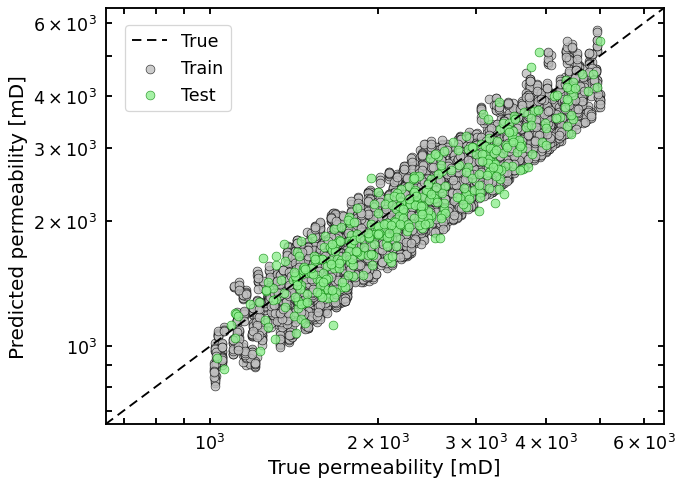

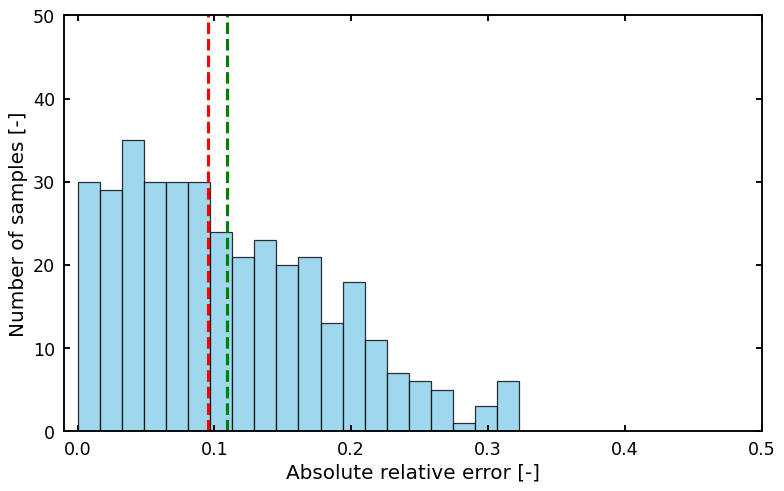

In [15]:
# LateX format for plots
# mpl.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})
mpl.rcParams.update(mpl.rcParamsDefault)

# set plot resoluton
plt.rcParams["figure.dpi"] = 120
plt.rcParams['axes.linewidth'] = 1.5
#
# Scatter plot Log scale Train and Test sets
#
font_size = 16
log_base = 10
max = 6500
min = max/log_base
x1 = data_summary_train["true"]
y1 = data_summary_train["hat"]
x2 = data_summary_test["true"]
y2 = data_summary_test["hat"]
#
plt.figure(figsize=(8, 6), dpi=90)
plt.plot([min, max], [min, max], color='k', linestyle='--', dashes=(5, 3), linewidth=1.5, alpha=1)
#
plt.scatter(x1, y1, c='silver', s=50, alpha=0.8, edgecolors='k', linewidth=0.5)
plt.scatter(x2, y2, c='lightgreen', s=50, alpha=0.8, edgecolors='g', linewidth=0.5)
#
plt.ylim([min, max])
plt.xlim([min, max])
#
plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in", pad=7, length=5, width=1.5, labelsize=font_size-2, axis='both', which='both')
plt.loglog(base=log_base)
plt.legend(['True', 'Train', 'Test'], loc='upper left',fontsize=font_size-2, bbox_to_anchor=(0.02, 0.98))
plt.ylabel('Predicted permeability [mD]', size=font_size)
plt.xlabel('True permeability [mD]', size=font_size)
plt.title("", size=font_size)
plt.savefig(save_name+'/predictions_tt_scatter_log.png', bbox_inches='tight', dpi=400)
plt.savefig(save_name+'/predictions_tt_scatter_log.pdf', bbox_inches='tight', dpi=400)
plt.show()
# plt.clf()
## Plot histograms
x = data_summary_test['ARE']
color = 'skyblue'
bins = 20
plt.figure(figsize=(10, 6), dpi=90)
plt.hist(x, bins=bins, color=color, alpha= 0.8, edgecolor='black', linewidth=1)
plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in", pad=7, length=5, width=1.5, labelsize=font_size-2)
plt.ylim(-0.01, 50)
plt.xlim(-0.01, 0.5)
MARE = np.mean(abs(x))
MedRE = np.median(abs(x))
plt.axvline(MARE, color='g', linestyle='dashed', linewidth=2.5)
plt.axvline(MedRE, color='r', linestyle='dashed', linewidth=2.5)
plt.ylabel('Number of samples [-]', size=font_size)
plt.xlabel('Absolute relative error [-]', size=font_size)
plt.savefig(save_name+'/ARE_hist.png', bbox_inches='tight', dpi=400)
plt.savefig(save_name+'/ARE_hist.pdf', bbox_inches='tight', dpi=400)
#plt.savefig('K_hist.eps', format='eps')
plt.show()
#plt.clf()
